# CPU pipeline to load/process and reconstruct tomographic data
<span style="color:magenta">In this example, we use the I/O functionality of HTTomo to load tomographic data, apply some processing and do the reconstruct ion. Most of the methods are used directly from the TomoPy software. This is an example of the serial run with multithreading enabled for methods locally. Similarly, the parallel excecution can be initialised with MPI.</span>

In [1]:
import sys
from datetime import datetime
import os
from os import mkdir
import matplotlib.pyplot as plt

from mpi4py import MPI
import numpy as np
from nvtx import annotate
import multiprocessing
import tomopy

from httomo.common import PipelineTasks
from httomo.data.hdf.loaders import standard_tomo
from httomo.data.hdf._utils.save import intermediate_dataset
from httomo.data.hdf._utils.reslice import reslice

#### Set I/O and parameters

In [20]:
# set I/O and other parameters
current_dir = os.getcwd()

in_file = os.path.join(current_dir, "../../testdata" ,"tomo_standard.nxs")
run_out_dir_main = os.path.join(current_dir, "../../testdata" ,"output_temp")
run_out_dir = os.path.join(current_dir, "../../testdata" ,"output_temp", f"{datetime.now().strftime('%d-%m-%Y_%H_%M_%S')}_output")

name_dataset = "tomo"
data_path = "/entry1/tomo_entry/data/data"
image_key_path = "/entry1/tomo_entry/instrument/detector/image_key"
dimension = 1 # load chunks projection-wise
pad = 0 # padding data parameter
preview = [None, None, None]

comm = MPI.COMM_WORLD
if comm.rank == 0:
    if not os.path.exists(run_out_dir_main):
        os.makedirs(run_out_dir_main)    
    mkdir(run_out_dir)    
if comm.size == 1:
    ncore = multiprocessing.cpu_count() # use all available CPU cores if not an MPI run

#### Loading and visualising the tomographic data...

The full dataset shape is (220, 128, 160)
[0] Pad values are (0, 0).
/home/algol/Documents/DEV/HTTomo/jupyter_nb/general/../../testdata/tomo_standard.nxs
/entry1/tomo_entry/data/data
0:180, :, :
[0] Data shape is (180, 128, 160) of type uint16


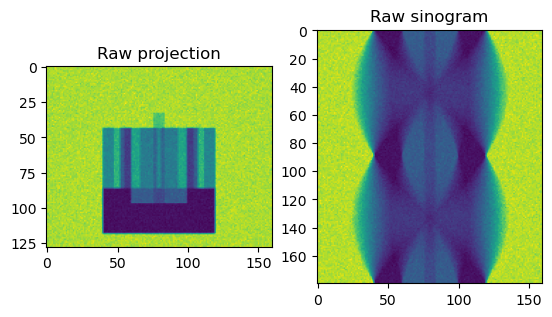

In [21]:
data, flats, darks, angles, angles_total, detector_y, detector_x = standard_tomo(name_dataset,
                                                                                 in_file, 
                                                                                 data_path,
                                                                                 image_key_path,
                                                                                 dimension,
                                                                                 preview,
                                                                                 pad,
                                                                                 comm)

plt.figure()
plt.subplot(121)
plt.imshow(data[90,:,:])
plt.title('Raw projection')
plt.subplot(122)
plt.imshow(data[:,90,:])
plt.title('Raw sinogram')
plt.show()

#### Apply 3d median filter from HTTomo to raw data/flats/darks

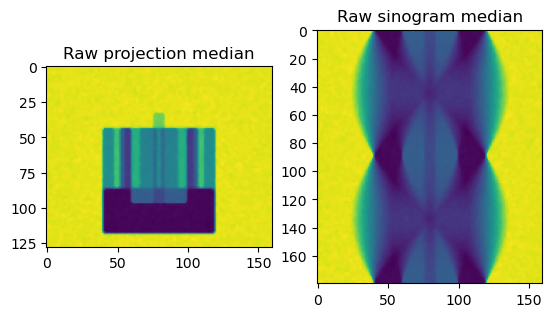

In [22]:
from httomo.misc.corr import median_filter3d

data = median_filter3d(data, radius_kernel=1, ncore=ncore)
flats = median_filter3d(flats, radius_kernel=1, ncore=ncore)
darks = median_filter3d(darks, radius_kernel=1, ncore=ncore)

plt.figure()
plt.subplot(121)
plt.imshow(data[90,:,:])
plt.title('Raw projection median')
plt.subplot(122)
plt.imshow(data[:,90,:])
plt.title('Raw sinogram median')
plt.show()

#### Normalising the data using TomoPy

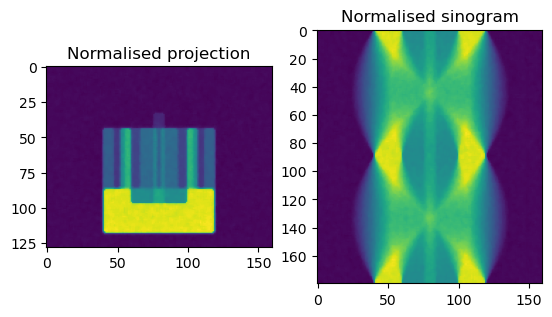

In [23]:
from tomopy.prep.normalize import normalize, minus_log
data = normalize(data, flats, darks, ncore=ncore, cutoff=10)
data[data == 0.0] = 1e-09
data = tomopy.minus_log(data, ncore=ncore)

plt.figure()
plt.subplot(121)
plt.imshow(data[90,:,:])
plt.title('Normalised projection')
plt.subplot(122)
plt.imshow(data[:,90,:])
plt.title('Normalised sinogram')
plt.show()

#### Finding the center of rotation (CoR)

In [24]:
from tomopy.recon.rotation import find_center_vo

rot_center = 0
mid_rank = int(round(comm.size / 2) + 0.1)
if comm.rank == mid_rank:
    mid_slice = int(np.size(data, 1) / 2)
    rot_center = find_center_vo(data, 
                                ind=mid_slice, 
                                smin=-50, 
                                smax=50, 
                                srad=6, 
                                step=0.5, 
                                ratio=0.5, 
                                drop=20, 
                                ncore=ncore)
rot_center = comm.bcast(rot_center, root=mid_rank)
print(f"Found CoR {rot_center}", comm)

Found CoR 79.5 <mpi4py.MPI.Intracomm object at 0x7f56c90dfea0>


#### Save intermediate dataset and reslice to change chunking from projection to sinogram

In [25]:
data, dimension = reslice(data, run_out_dir, dimension, angles_total, detector_y, detector_x, comm)

/home/algol/Documents/DEV/HTTomo/jupyter_nb/general/../../testdata/output_temp/14-11-2022_13_55_57_output/intermediate.h5
/data
:,:,:


#### Reconstruct the data

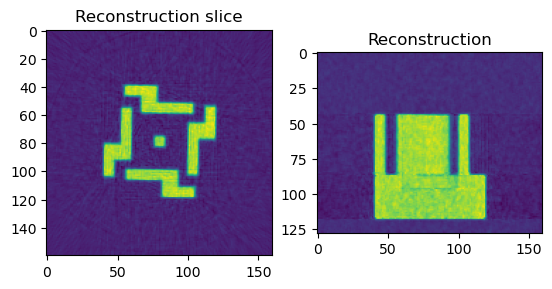

In [27]:
from tomopy.recon.algorithm import recon

reconstruction = recon(data,
    angles,
    center=rot_center,
    algorithm="gridrec",
    sinogram_order=False,
    ncore=ncore)

plt.figure()
plt.subplot(121)
plt.imshow(reconstruction[50,:,:])
plt.title('Reconstruction slice')
plt.subplot(122)
plt.imshow(reconstruction[:,100,:])
plt.title('Reconstruction')
plt.show()